# 13. Frame Selected Stability

In [1]:
from src import *

/home/chunhei/miniconda3/envs/gradients_emo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Description

We look in this section for the stability of frame selected gradients across subjects (individual gradients approach) and also how stable the group gradients are when frame selecting compared to when full is used. 

GOAL: Evaluate differences of individual gradients of selected gradients and movie long gradients + evaluate differences of group gradients of selected timeseries and group gradients of full movies 

## Table of Contents
- [Frame selected emotion gradients](#comparison)

In [2]:
mri_path400 = "./data/fmri414_compiled/"

<a class="anchor" id="comparison"></a>
## Frame selected (by emotion) gradients

### Defining Emotion Intensity

In [3]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

tmpdf = pd.read_csv('./data/emotion_compileBIDS.csv')

In [4]:
# Compute intensity metrics:
tmp_series = {}
for moviename in tmpdf.filename.unique():
    tmp_series[moviename] = []
    cur_series = tmpdf[tmpdf.filename==moviename]
    for idx,s in enumerate(select):
        distrib = list(cur_series[cur_series.item == s]['score'])
        if len(distrib) == 0: continue
        tmp_series[moviename].append(distrib)

# 1. Sum squares combining all emotions for each movie
intensity1_series = {}
for moviename in tmpdf.filename.unique():
    intensity1_series[moviename] = (np.asarray(tmp_series[moviename]) ** 2).sum(axis=0)
    
# 2. Averaging groups of emotions [detailed below] then sum squares combining
groups = [["Guilt", "Anger", "Disgust"], ["Sad"], ["Anxiety", "Fear", "Surprise"], ["Satisfaction", "Happiness", "Pride"], ["Love", "WarmHeartedness", "Regard"]]
groups_idx = np.asarray([[1, 0, 3], [12], [7, 5, 10], [8, 4, 9], [11, 2, 6]])
intensity2_series = {}
for moviename in tmpdf.filename.unique():
    tmp2_series = []
    # averaging per group (intermatiate mapping)
    for gidx in groups_idx:
        tmp2_series.append(np.asarray(tmp_series[moviename])[gidx].mean(axis=0))
    intensity2_series[moviename] = (np.asarray(tmp2_series) ** 2).sum(axis=0)

# 3. Averaging groups of positive emotions and negative emotions separately then sum squares combining both groups
groups = [["Guilt", "Anger", "Disgust", "Sad", "Anxiety", "Fear", "Surprise"], ["Satisfaction", "Happiness", "Pride", "Love", "WarmHeartedness", "Regard"]]
groups_idx = np.asarray([[1, 0, 3, 12, 7, 5, 10], [8, 4, 9, 11, 2, 6]])
intensity3_series = {}
for moviename in tmpdf.filename.unique():
    tmp2_series = []
    # averaging per group (intermatiate mapping)
    for gidx in groups_idx:
        tmp2_series.append(np.asarray(tmp_series[moviename])[gidx].mean(axis=0))
    intensity3_series[moviename] = (np.asarray(tmp2_series) ** 2).sum(axis=0)

/tmp/ipykernel_137320/3462044138.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups_idx = np.asarray([[1, 0, 3], [12], [7, 5, 10], [8, 4, 9], [11, 2, 6]])
/tmp/ipykernel_137320/3462044138.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups_idx = np.asarray([[1, 0, 3, 12, 7, 5, 10], [8, 4, 9, 11, 2, 6]])


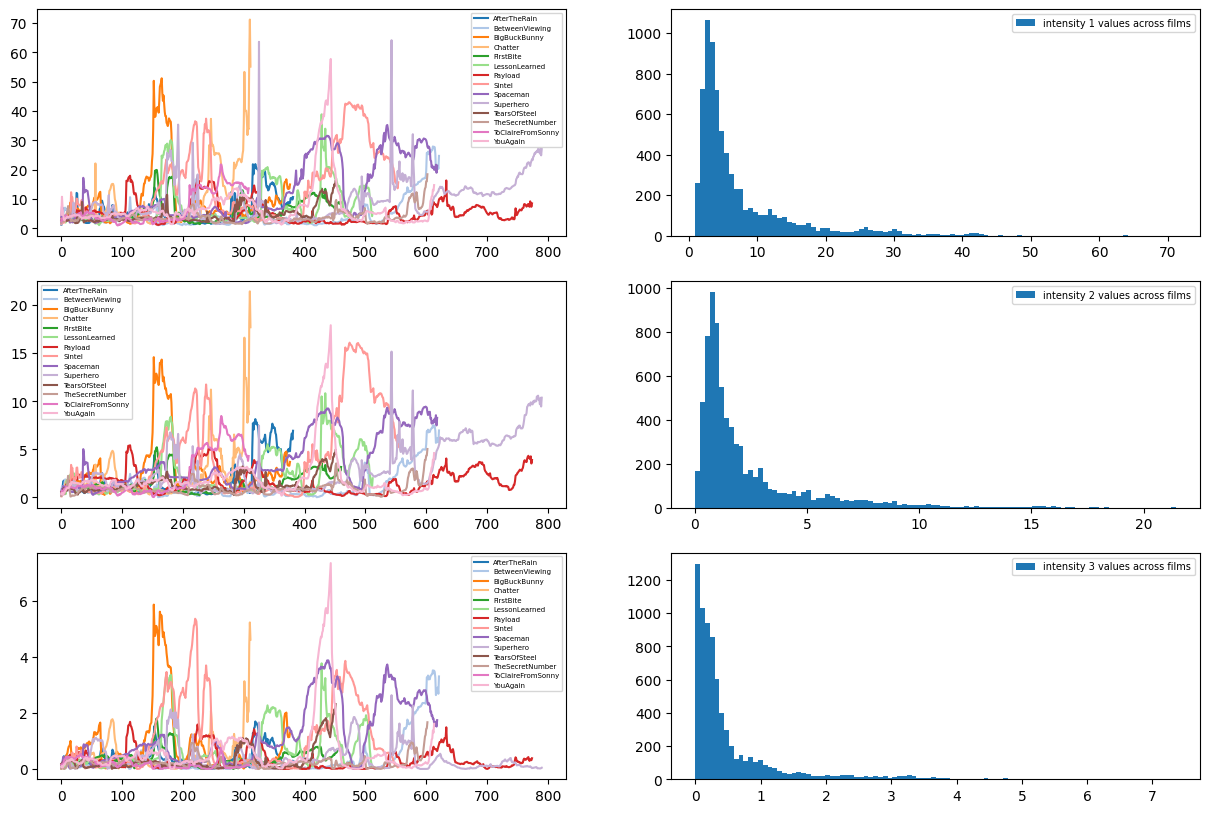

In [5]:
from matplotlib.colors import ListedColormap
intensity_scores = [intensity1_series, intensity2_series, intensity3_series]
# Displaying
pal     = sns.color_palette('tab20', len(tmpdf.filename.unique()))
my_cmap = ListedColormap(pal)
fig, ax = plt.subplots(3,2,figsize=(15,10))

# Scores
for k in range(3):
    for idx,moviename in enumerate(tmpdf.filename.unique()):
        ax[k,0].plot(intensity_scores[k][moviename], label=moviename[2:-6], color=my_cmap.colors[idx])
    ax[k,0].legend(prop={'size':5})

    distrib = np.concatenate(list(intensity_scores[k].values()))
    ax[k,1].hist(distrib, bins=100, label='intensity {} values across films'.format(k+1))
    ax[k,1].legend(prop={'size':7})


# threshold according for now: 80 percentile until 95 percentile 1 step at a time
T = [40,50,60,70,80]
thresholds = [[np.percentile(np.concatenate(list(intensity_scores[k].values())), T[i]) for i in range(len(T))] for k in range(3)]

### Select frames (timecourses of fmri) according to the previously defined cutoff

In [6]:
# First find all timestamps/frames with a high enough intensity (high according to previous scoring scheme)

# FRAME SELECT ON EMOTIONS
for mnumb in range(3):
    for t in tqdm(range(len(thresholds[mnumb]))):
        selected_series = {m.split('_')[0]:[] for m in os.listdir(mri_path400)}
        for movie_name400 in tqdm(os.listdir(mri_path400)):
            if "Rest" in movie_name400: continue        
            mri_df400mov  = pd.read_csv(mri_path400 + movie_name400)
            mname         = movie_name400.split('_')[0]
            
            film_duration = FILM2DURATION[mname] # in seconds
            duration_film = int(film_duration/ TR) # in number of TRs
            front_pad     = int(WASH + ONSET) + 1

            # Simply replace 400 by 414 to look at spatial relation with subcortical regions included
            movies = [m for m in mri_df400mov.filename.unique() if "414" in m] 
            movie_series = []
            for m in movies:
                tmp1, _  = df_to_timeseries(mri_df400mov, m)
                tmp1     = tmp1[front_pad :  front_pad + duration_film]
                movie_series.append(tmp1)
            movie_series = np.asarray(movie_series)

            
            tmp = intensity_scores[mnumb]['W_{}13.csv'.format(mname)]
            tmp = tmp[:movie_series.shape[1]]

            # select from emotion timeseries frames with strong emotions
            frame_select = np.where(tmp > thresholds[mnumb][t])[0]
            # append volume fmri corresponding to timestamp of intense positive emotion
            selected_series[mname] = movie_series[:,frame_select]
        
        save('./resources/threshes/tresh{}-{}.pkl'.format(T[t], mnumb), selected_series)

100%|██████████| 5/5 [19:46<00:00, 237.35s/it]


### Gradients Computation

In [6]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

1. Frame selection compute

In [8]:
# individual variance variables
fselect_subjects_gradients = {}

# bootstrap variables
sample_size = 25
resample_nb = 100
fselect_bootstrap_gradients = {}

np.random.seed(19)
for tpath in os.listdir("./resources/threshes/"):
    selected_series = load('./resources/threshes/{}'.format(tpath))

    # concatenate on different frames across movies
    # basically doing reordering of columns
    subject_tmpseries = [[] for _ in range(30)]
    tmp = list(selected_series.values())
    for i in range(len(tmp)):
        if len(tmp[i]) == 0: continue
        for nsub in range(30):
            subject_tmpseries[nsub].append(tmp[i][nsub])

    subject_series = []
    for i in range(30):
        subject_series.append(np.concatenate(subject_tmpseries[i]))

    # 1. Compute individual gradients according to selected frames
    subjects_gradients = []
    for nsub in range(30):
        tmp_series = np.asarray(subject_series)[nsub]
        fc_selects = FC(tmp_series)
        g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
        g_selects.fit(fc_selects)
        subjects_gradients.append(g_selects.gradients_)

    # alignement across all gradients
    select_subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
    select_subjects_gradients = np.asarray(select_subjects_gradients)
    fselect_subjects_gradients[tpath.split('.')[0]] = select_subjects_gradients


    # 2. Compute bootrstrap group gradients according to selected frames
    bootstrap_gradients = []
    for rnb in range(resample_nb):
        index_choice = np.random.choice(np.arange(30), sample_size, replace=False)
        tmp_series = np.concatenate(np.array(subject_series)[index_choice])
        fc_selects = FC(tmp_series)
        g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
        g_selects.fit(fc_selects)
        bootstrap_gradients.append(g_selects.gradients_)
    # alignement across all gradients
    select_bootstrap_gradients,_,s = procrustes_align(np.asarray(bootstrap_gradients))
    select_bootstrap_gradients = np.asarray(select_bootstrap_gradients)
    fselect_bootstrap_gradients[tpath.split('.')[0]] = select_bootstrap_gradients

In [69]:
# save('fselect_subjects_gradients.pkl',fselect_subjects_gradients)
# save('fselect_bootstrap_gradients.pkl',fselect_bootstrap_gradients)

2. Full Film Gradients Computation 

In [8]:
# bootstrap variables
sample_size = 25
resample_nb = 100

mri_df = pd.read_csv(mri_path400 + 'Rest_compiled414.csv')
front_pad = 0
end       = -1

rest_subject_series = []
rest_subjects_gradients = []
acqui        = [k for k in mri_df.filename.unique() if '414' in k]

# 1. Individual gradients computation
for filename_movie in acqui:
    tmp_series, _ = df_to_timeseries(mri_df, filename_movie)

    tmp_series    = tmp_series[front_pad : end]
    fc = FC(tmp_series)
    g = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g.fit(fc)
    rest_subjects_gradients.append(g.gradients_)    
    rest_subject_series.append(tmp_series)

# 2. Bootstrap gradients computation
rest_bootstrap_gradients = []
for rnb in tqdm(range(resample_nb)):
    index_choice = np.random.choice(np.arange(30), sample_size, replace=False)
    tmp_series = np.concatenate(np.array(rest_subject_series)[index_choice])
    fc = FC(tmp_series)
    g = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g.fit(fc)
    rest_bootstrap_gradients.append(g.gradients_)

100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


In [10]:
rest_subjects_gradients,_,s = procrustes_align(np.asarray(rest_subjects_gradients))
rest_subjects_gradients = np.asarray(rest_subjects_gradients)

rest_bootstrap_gradients,_,s = procrustes_align(np.asarray(rest_bootstrap_gradients))
rest_bootstrap_gradients = np.asarray(rest_bootstrap_gradients)

In [16]:
# save('rest_subjects_gradients.pkl',rest_subjects_gradients)
# save('rest_bootstrap_gradients.pkl',rest_bootstrap_gradients)

3. Full Film Gradients Computation 

In [11]:
tmp_movie_series = {}
subjects_movie_series = []
for i in tqdm(range(len(os.listdir(mri_path400)))):
    movie_name   = os.listdir(mri_path400)[i]
    mri_df       = pd.read_csv(mri_path400 + movie_name)
    
    if 'Rest' in movie_name: 
        continue

    film_duration = FILM2DURATION[movie_name.split('_')[0]] # in second
    duration_film = int(film_duration/ TR) # in number of TRs
    front_pad     = int(WASH + ONSET) + 1
    end           = front_pad + duration_film

    acqui        = [k for k in mri_df.filename.unique() if '414' in k]
    for filename_movie in acqui:
        subject         = filename_movie.split('_')[2].split('-')[1]
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : end]
        if subject not in tmp_movie_series:
            tmp_movie_series[subject] = [movie_series]
        else:
            tmp_movie_series[subject].append(movie_series)

for subj in tmp_movie_series:
    subjects_movie_series.append(np.concatenate(tmp_movie_series[subj]))

 47%|████▋     | 7/15 [02:05<02:02, 15.27s/it]

Rest_compiled414.csv


100%|██████████| 15/15 [04:25<00:00, 17.70s/it]


In [12]:
# 1. Individual gradients computation
full_subjects_gradients = []
for k in range(30):
    tmp_series = subjects_movie_series[k]
    fc = FC(tmp_series)
    g = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g.fit(fc)
    full_subjects_gradients.append(g.gradients_)

# 2. Bootstrap gradients computation
full_bootstrap_gradients = []
for rnb in tqdm(range(resample_nb)):
    index_choice = np.random.choice(np.arange(30), sample_size, replace=False)
    tmp_series = np.concatenate(np.array(subjects_movie_series)[index_choice])
    fc = FC(tmp_series)
    g = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g.fit(fc)
    full_bootstrap_gradients.append(g.gradients_)

100%|██████████| 100/100 [04:24<00:00,  2.64s/it]


In [13]:
full_subjects_gradients,_,s = procrustes_align(np.asarray(full_subjects_gradients))
full_subjects_gradients = np.asarray(full_subjects_gradients)

full_bootstrap_gradients,_,s = procrustes_align(np.asarray(full_bootstrap_gradients))
full_bootstrap_gradients = np.asarray(full_bootstrap_gradients)

In [15]:
# save('full_subjects_gradients.pkl',full_subjects_gradients)
# save('full_bootstrap_gradients.pkl',full_bootstrap_gradients)

### Evaluate By eyeballing

In [20]:
fselect_subjects_gradients = load('./resources/f-select_grad/fselect_subjects_gradients.pkl')
fselect_bootstrap_gradients = load('./resources/f-select_grad/fselect_bootstrap_gradients.pkl')

full_subjects_gradients = load('./resources/f-select_grad/full_subjects_gradients.pkl')
full_bootstrap_gradients = load('./resources/f-select_grad/full_bootstrap_gradients.pkl')

rest_subjects_gradients = load('./resources/f-select_grad/rest_subjects_gradients.pkl')
rest_bootstrap_gradients = load('./resources/f-select_grad/rest_bootstrap_gradients.pkl')

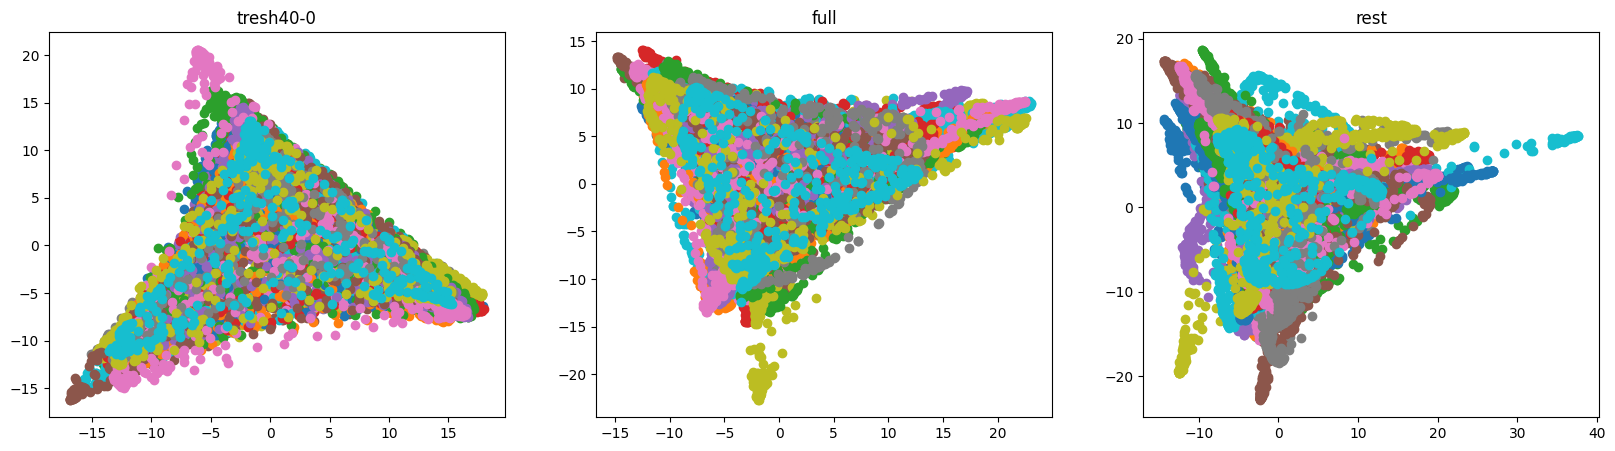

In [29]:
# quick viz
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i in range(30):
    ax[0].scatter(fselect_subjects_gradients['tresh40-0'][i,:,0], fselect_subjects_gradients['tresh40-0'][i,:,1], label='tresh40-0')
    ax[0].set_title('tresh40-0')
for i in range(30):
    ax[1].scatter(full_subjects_gradients[i,:,0], full_subjects_gradients[i,:,1], label='full')
    ax[1].set_title('full')
for i in range(30):
    ax[2].scatter(rest_subjects_gradients[i,:,0], rest_subjects_gradients[i,:,1], label='rest')
    ax[2].set_title('rest')


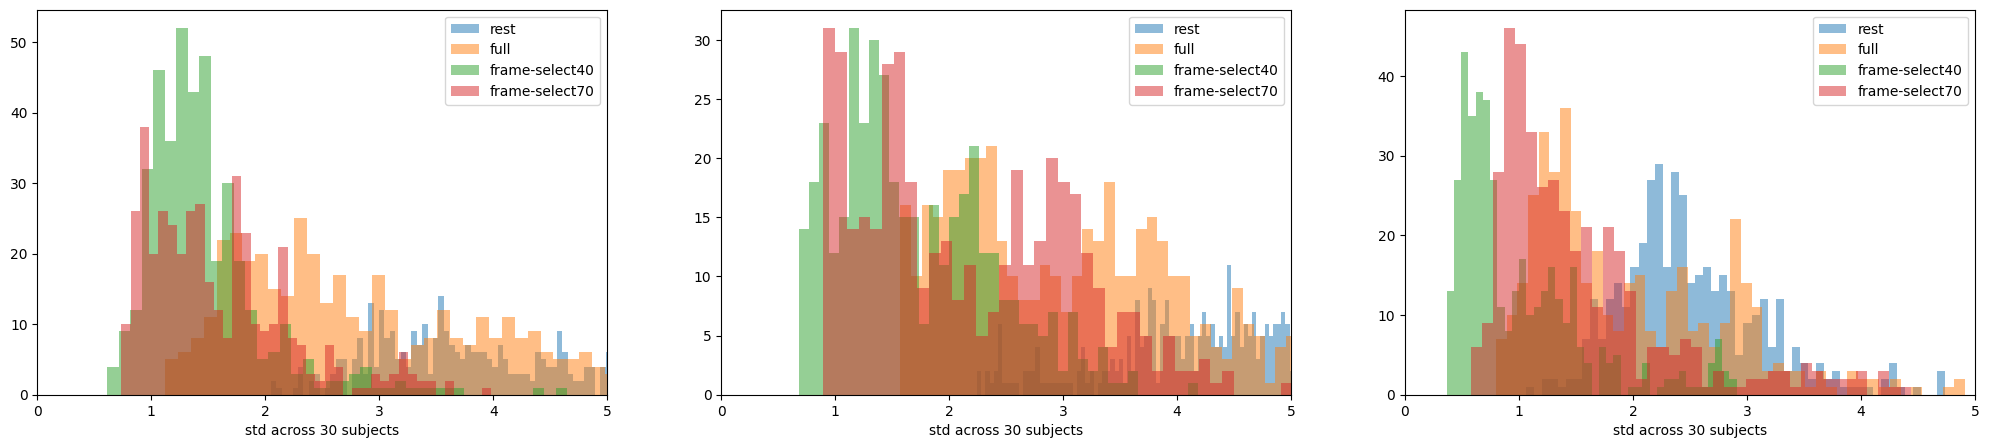

In [25]:
# Evaluate variance , first displaying macro levels distributions of variance as comparison side by side of static 
fig, ax = plt.subplots(1,3, figsize=(25,5))

for gradix in range(3):
    ax[gradix].hist(np.std(rest_subjects_gradients[:,:,gradix], axis=0), label='rest', bins=150, alpha=0.5)
    ax[gradix].hist(np.std(full_subjects_gradients[:,:,gradix], axis=0), label='full', bins=50, alpha=0.5)

    for i in [0,3]:
        tmp_gradients = fselect_subjects_gradients['tresh{}-1'.format(T[i])]
        ax[gradix].hist(np.std(tmp_gradients[:,:,gradix], axis=0), label='frame-select{}'.format(T[i]), bins=40, alpha=0.5)

    ax[gradix].set_xlim(0,5)
    ax[gradix].legend()
    ax[gradix].set_xlabel('std across 30 subjects')

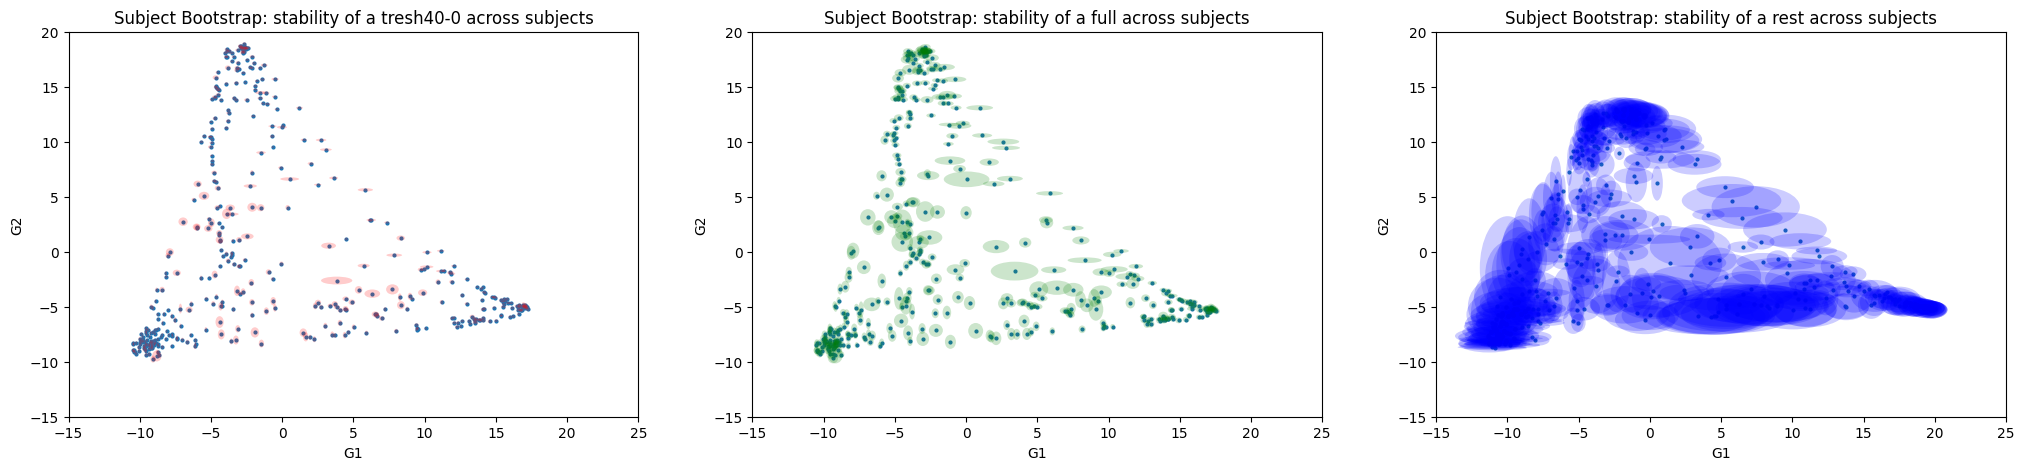

In [47]:
# Evaluate bootstrapped variance, first displaying macro levels distributions of variance as comparison side by side of static 
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,3, figsize=(25,5))

score_labels = ['tresh40-0', 'full', 'rest']
colors = ['r','g','b']

gradidx = [0,1]
for k in range(3):

    if k == 0:
        aligned = fselect_bootstrap_gradients[score_labels[0]][:,:,gradidx]
    elif k ==1:
        aligned = full_bootstrap_gradients[:,:,gradidx]
    else:
        aligned = rest_bootstrap_gradients[:,:,gradidx]
        
    circle_confusion = aligned.std(axis=0)[:,[0,1]]
    ref = aligned.mean(axis=0)
    ref,_,_ = procrustes_align([ref], ref=rest_bootstrap_gradients[:,:,gradidx].mean(axis=0))
    ref = ref[0]
    
    axes[k].scatter(ref[:,0], ref[:,1], s=4)

    for i in range(len(circle_confusion)):
        pts = circle_confusion[i]
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[k], alpha=0.2)

        # axes[row,col].add_artist(cc)
        axes[k].add_patch(ellipse)

    axes[k].set_title("Subject Bootstrap: stability of a {} across subjects".format(score_labels[k]), size=12)

    axes[k].set_xlim(-15,25)
    axes[k].set_ylim(-15,20)
    axes[k].set_xlabel('G{}'.format(gradidx[0]+1))
    axes[k].set_ylabel('G{}'.format(gradidx[1]+1))

plt.show()

### Evaluate statistical differences (mainly two-way ANOVA)

Evaluate Variance across individuals

In [85]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [73]:
# Evaluate variance 

# Performing two-way ANOVA
yeo2region = load('./resources/yeo7region414.pkl')
networks   = list(yeo2region.keys())

gidx = 2
rest_score = rest_subjects_gradients[:,:,gidx].std(axis=0)
full_score = full_subjects_gradients[:,:,gidx].std(axis=0)
fselect0_score = fselect_subjects_gradients['tresh{}-1'.format(T[0])][:,:,gidx].std(axis=0)
fselect1_score = fselect_subjects_gradients['tresh{}-1'.format(T[1])][:,:,gidx].std(axis=0)
fselect2_score = fselect_subjects_gradients['tresh{}-1'.format(T[2])][:,:,gidx].std(axis=0)
fselect3_score = fselect_subjects_gradients['tresh{}-1'.format(T[3])][:,:,gidx].std(axis=0)
fselect4_score = fselect_subjects_gradients['tresh{}-1'.format(T[4])][:,:,gidx].std(axis=0)

df = {"score": [], "cond": [], 'network': []}
for n in networks:

    df['score'] += list(rest_score[yeo2region[n]])
    df['score'] += list(full_score[yeo2region[n]])
    df['score'] += list(fselect0_score[yeo2region[n]])
    df['score'] += list(fselect1_score[yeo2region[n]])
    df['score'] += list(fselect2_score[yeo2region[n]])
    df['score'] += list(fselect3_score[yeo2region[n]])
    df['score'] += list(fselect4_score[yeo2region[n]])

    df['cond']  += ['rest'] * len(yeo2region[n])
    df['cond']  += ['fullmovie'] * len(yeo2region[n])
    df['cond']  += ['fselect0'] * len(yeo2region[n])
    df['cond']  += ['fselect1'] * len(yeo2region[n])
    df['cond']  += ['fselect2'] * len(yeo2region[n])
    df['cond']  += ['fselect3'] * len(yeo2region[n])
    df['cond']  += ['fselect4'] * len(yeo2region[n])

    df['network'] += [n] * 7 * len(yeo2region[n])
    
df = pd.DataFrame.from_dict(df)


model = ols('score ~ C(cond) + C(network) + C(cond):C(network)',data=df).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)
# print(result.to_latex())

                        df       sum_sq     mean_sq           F         PR(>F)
C(cond)                6.0   728.254552  121.375759  299.271643  9.439664e-298
C(network)             7.0   481.567924   68.795418  169.626274  3.909698e-210
C(cond):C(network)    42.0    70.257824    1.672805    4.124573   3.257169e-17
Residual            2842.0  1152.631443    0.405571         NaN            NaN


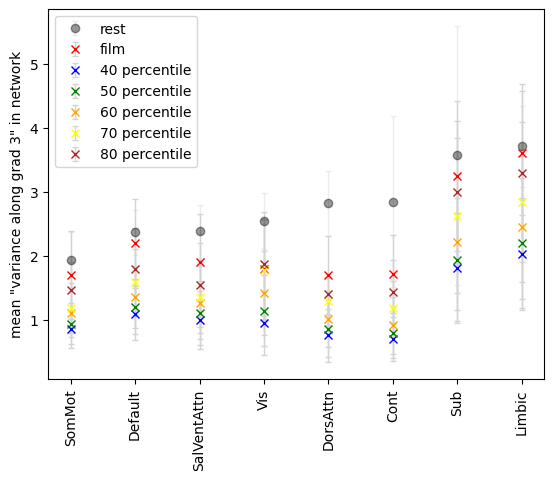

In [82]:
# plot of scatter
rest_df  = df[df.cond == 'rest']
movie_df = df[df.cond == 'fullmovie']
f0_df = df[df.cond == 'fselect0']
f1_df = df[df.cond == 'fselect1']
f2_df = df[df.cond == 'fselect2']
f3_df = df[df.cond == 'fselect3']
f4_df = df[df.cond == 'fselect4']

rest_arr  = []
movie_arr = []
f0_arr = []
f1_arr = []
f2_arr = []
f3_arr = []
f4_arr = []

for n in networks:
    cur = np.array(rest_df[rest_df.network==n]['score'])
    rest_arr.append([cur.mean(), cur.std()])
    
    cur = np.array(movie_df[movie_df.network==n]['score'])
    movie_arr.append([cur.mean(), cur.std()])

    cur = np.array(f0_df[f0_df.network==n]['score'])
    f0_arr.append([cur.mean(), cur.std()])

    cur = np.array(f1_df[f1_df.network==n]['score'])
    f1_arr.append([cur.mean(), cur.std()])

    cur = np.array(f2_df[f2_df.network==n]['score'])
    f2_arr.append([cur.mean(), cur.std()])

    cur = np.array(f3_df[f3_df.network==n]['score'])
    f3_arr.append([cur.mean(), cur.std()])

    cur = np.array(f4_df[f4_df.network==n]['score'])
    f4_arr.append([cur.mean(), cur.std()])
    
rest_arr  = np.asarray(rest_arr)
movie_arr = np.asarray(movie_arr)
f0_arr = np.asarray(f0_arr)
f1_arr = np.asarray(f1_arr)
f2_arr = np.asarray(f2_arr)
f3_arr = np.asarray(f3_arr)
f4_arr = np.asarray(f4_arr)

order     = np.argsort(rest_arr[:,0])
rest_arr  = rest_arr[order]
movie_arr = movie_arr[order]
f0_arr    = f0_arr[order]
f1_arr    = f1_arr[order]
f2_arr    = f2_arr[order]
f3_arr    = f3_arr[order]
f4_arr    = f4_arr[order]

plt.errorbar(list(range(rest_arr.shape[0])), rest_arr[:,0], yerr=rest_arr[:,1], fmt='o', color='black',
             ecolor='lightgray', elinewidth=1, capsize=2, alpha=0.4, label='rest')

plt.errorbar(list(range(movie_arr.shape[0])), movie_arr[:,0], yerr=movie_arr[:,1], fmt='x', color='red',
             ecolor='lightgray', elinewidth=1, capsize=2, label='film')

plt.errorbar(list(range(f0_arr.shape[0])), f0_arr[:,0], yerr=f0_arr[:,1], fmt='x', color='blue',
             ecolor='lightgray', elinewidth=1, capsize=2, label='40 percentile')

plt.errorbar(list(range(f1_arr.shape[0])), f1_arr[:,0], yerr=f1_arr[:,1], fmt='x', color='green',
             ecolor='lightgray', elinewidth=1, capsize=2, label='50 percentile')

plt.errorbar(list(range(f2_arr.shape[0])), f2_arr[:,0], yerr=f2_arr[:,1], fmt='x', color='orange',
             ecolor='lightgray', elinewidth=1, capsize=2, label='60 percentile')

plt.errorbar(list(range(f3_arr.shape[0])), f3_arr[:,0], yerr=f3_arr[:,1], fmt='x', color='yellow',
             ecolor='lightgray', elinewidth=1, capsize=2, label='70 percentile')

plt.errorbar(list(range(f4_arr.shape[0])), f4_arr[:,0], yerr=f4_arr[:,1], fmt='x', color='brown',
             ecolor='lightgray', elinewidth=1, capsize=2, label='80 percentile')
    
plt.ylabel('mean "variance along grad {}" in network'.format(gidx+1))
# plt.xlabel('networks')
plt.xticks(list(range(rest_arr.shape[0])), 
           np.array(networks)[order], rotation=90)
plt.legend()
plt.show()

In [84]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df['score'],
                          groups=df['cond'],
                          alpha=0.05)

print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
 fselect0  fselect1   0.1227 0.2446 -0.0348 0.2802  False
 fselect0  fselect2   0.3035    0.0  0.1461  0.461   True
 fselect0  fselect3   0.5362    0.0  0.3787 0.6936   True
 fselect0  fselect4   0.7542    0.0  0.5968 0.9117   True
 fselect0 fullmovie   1.0123    0.0  0.8548 1.1697   True
 fselect0      rest   1.5414    0.0  1.3839 1.6988   True
 fselect1  fselect2   0.1808 0.0126  0.0233 0.3383   True
 fselect1  fselect3   0.4135    0.0   0.256 0.5709   True
 fselect1  fselect4   0.6315    0.0  0.4741  0.789   True
 fselect1 fullmovie   0.8896    0.0  0.7321  1.047   True
 fselect1      rest   1.4187    0.0  1.2612 1.5761   True
 fselect2  fselect3   0.2327 0.0003  0.0752 0.3901   True
 fselect2  fselect4   0.4507    0.0  0.2933 0.6082   True
 fselect2 fullmovie   0.7088    0.0  0.5513 0.8662   True
 fselect2     

Evaluate on bootstrap of computation of gradients

In [86]:
# Performing two-way ANOVA
yeo2region = load('./resources/yeo7region414.pkl')
networks   = list(yeo2region.keys())

gidx = 2
rest_score = rest_bootstrap_gradients[:,:,gidx].std(axis=0)
full_score = full_bootstrap_gradients[:,:,gidx].std(axis=0)
fselect0_score = fselect_bootstrap_gradients['tresh{}-1'.format(T[0])][:,:,gidx].std(axis=0)
fselect1_score = fselect_bootstrap_gradients['tresh{}-1'.format(T[1])][:,:,gidx].std(axis=0)
fselect2_score = fselect_bootstrap_gradients['tresh{}-1'.format(T[2])][:,:,gidx].std(axis=0)
fselect3_score = fselect_bootstrap_gradients['tresh{}-1'.format(T[3])][:,:,gidx].std(axis=0)
fselect4_score = fselect_bootstrap_gradients['tresh{}-1'.format(T[4])][:,:,gidx].std(axis=0)

df = {"score": [], "cond": [], 'network': []}
for n in networks:

    df['score'] += list(rest_score[yeo2region[n]])
    df['score'] += list(full_score[yeo2region[n]])
    df['score'] += list(fselect0_score[yeo2region[n]])
    df['score'] += list(fselect1_score[yeo2region[n]])
    df['score'] += list(fselect2_score[yeo2region[n]])
    df['score'] += list(fselect3_score[yeo2region[n]])
    df['score'] += list(fselect4_score[yeo2region[n]])

    df['cond']  += ['rest'] * len(yeo2region[n])
    df['cond']  += ['fullmovie'] * len(yeo2region[n])
    df['cond']  += ['fselect0'] * len(yeo2region[n])
    df['cond']  += ['fselect1'] * len(yeo2region[n])
    df['cond']  += ['fselect2'] * len(yeo2region[n])
    df['cond']  += ['fselect3'] * len(yeo2region[n])
    df['cond']  += ['fselect4'] * len(yeo2region[n])

    df['network'] += [n] * 7 * len(yeo2region[n])
    
df = pd.DataFrame.from_dict(df)


model = ols('score ~ C(cond) + C(network) + C(cond):C(network)',data=df).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)
# print(result.to_latex())

                        df      sum_sq    mean_sq           F        PR(>F)
C(cond)                6.0  172.041602  28.673600  927.946052  0.000000e+00
C(network)             7.0   11.701698   1.671671   54.099262  7.019265e-73
C(cond):C(network)    42.0   15.521058   0.369549   11.959487  7.260781e-73
Residual            2842.0   87.818006   0.030900         NaN           NaN


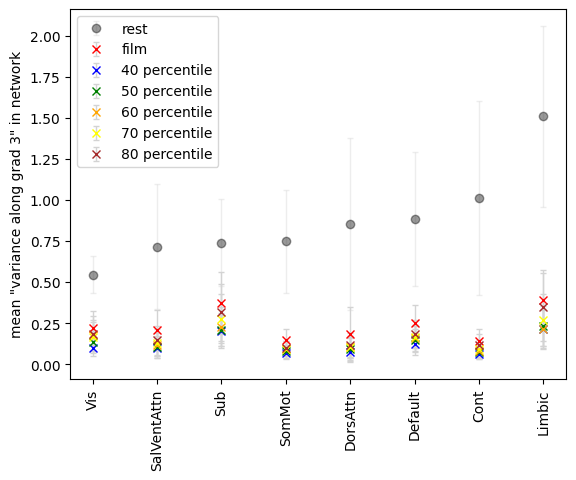

In [87]:
# plot of scatter
rest_df  = df[df.cond == 'rest']
movie_df = df[df.cond == 'fullmovie']
f0_df = df[df.cond == 'fselect0']
f1_df = df[df.cond == 'fselect1']
f2_df = df[df.cond == 'fselect2']
f3_df = df[df.cond == 'fselect3']
f4_df = df[df.cond == 'fselect4']

rest_arr  = []
movie_arr = []
f0_arr = []
f1_arr = []
f2_arr = []
f3_arr = []
f4_arr = []

for n in networks:
    cur = np.array(rest_df[rest_df.network==n]['score'])
    rest_arr.append([cur.mean(), cur.std()])
    
    cur = np.array(movie_df[movie_df.network==n]['score'])
    movie_arr.append([cur.mean(), cur.std()])

    cur = np.array(f0_df[f0_df.network==n]['score'])
    f0_arr.append([cur.mean(), cur.std()])

    cur = np.array(f1_df[f1_df.network==n]['score'])
    f1_arr.append([cur.mean(), cur.std()])

    cur = np.array(f2_df[f2_df.network==n]['score'])
    f2_arr.append([cur.mean(), cur.std()])

    cur = np.array(f3_df[f3_df.network==n]['score'])
    f3_arr.append([cur.mean(), cur.std()])

    cur = np.array(f4_df[f4_df.network==n]['score'])
    f4_arr.append([cur.mean(), cur.std()])
    
rest_arr  = np.asarray(rest_arr)
movie_arr = np.asarray(movie_arr)
f0_arr = np.asarray(f0_arr)
f1_arr = np.asarray(f1_arr)
f2_arr = np.asarray(f2_arr)
f3_arr = np.asarray(f3_arr)
f4_arr = np.asarray(f4_arr)

order     = np.argsort(rest_arr[:,0])
rest_arr  = rest_arr[order]
movie_arr = movie_arr[order]
f0_arr    = f0_arr[order]
f1_arr    = f1_arr[order]
f2_arr    = f2_arr[order]
f3_arr    = f3_arr[order]
f4_arr    = f4_arr[order]

plt.errorbar(list(range(rest_arr.shape[0])), rest_arr[:,0], yerr=rest_arr[:,1], fmt='o', color='black',
             ecolor='lightgray', elinewidth=1, capsize=2, alpha=0.4, label='rest')

plt.errorbar(list(range(movie_arr.shape[0])), movie_arr[:,0], yerr=movie_arr[:,1], fmt='x', color='red',
             ecolor='lightgray', elinewidth=1, capsize=2, label='film')

plt.errorbar(list(range(f0_arr.shape[0])), f0_arr[:,0], yerr=f0_arr[:,1], fmt='x', color='blue',
             ecolor='lightgray', elinewidth=1, capsize=2, label='40 percentile')

plt.errorbar(list(range(f1_arr.shape[0])), f1_arr[:,0], yerr=f1_arr[:,1], fmt='x', color='green',
             ecolor='lightgray', elinewidth=1, capsize=2, label='50 percentile')

plt.errorbar(list(range(f2_arr.shape[0])), f2_arr[:,0], yerr=f2_arr[:,1], fmt='x', color='orange',
             ecolor='lightgray', elinewidth=1, capsize=2, label='60 percentile')

plt.errorbar(list(range(f3_arr.shape[0])), f3_arr[:,0], yerr=f3_arr[:,1], fmt='x', color='yellow',
             ecolor='lightgray', elinewidth=1, capsize=2, label='70 percentile')

plt.errorbar(list(range(f4_arr.shape[0])), f4_arr[:,0], yerr=f4_arr[:,1], fmt='x', color='brown',
             ecolor='lightgray', elinewidth=1, capsize=2, label='80 percentile')
    
plt.ylabel('mean "variance along grad {}" in network'.format(gidx+1))
# plt.xlabel('networks')
plt.xticks(list(range(rest_arr.shape[0])), 
           np.array(networks)[order], rotation=90)
plt.legend()
plt.show()

In [88]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df['score'],
                          groups=df['cond'],
                          alpha=0.05)

print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
 fselect0  fselect1   0.0183  0.844 -0.0226 0.0592  False
 fselect0  fselect2   0.0336 0.1896 -0.0073 0.0745  False
 fselect0  fselect3   0.0413 0.0464  0.0004 0.0822   True
 fselect0  fselect4   0.0621 0.0002  0.0212  0.103   True
 fselect0 fullmovie   0.1113    0.0  0.0704 0.1522   True
 fselect0      rest   0.7343    0.0  0.6934 0.7752   True
 fselect1  fselect2   0.0153 0.9268 -0.0256 0.0562  False
 fselect1  fselect3    0.023 0.6435 -0.0179 0.0639  False
 fselect1  fselect4   0.0438 0.0266  0.0029 0.0847   True
 fselect1 fullmovie    0.093    0.0  0.0521 0.1339   True
 fselect1      rest   0.7161    0.0  0.6752  0.757   True
 fselect2  fselect3   0.0077  0.998 -0.0332 0.0486  False
 fselect2  fselect4   0.0285 0.3795 -0.0124 0.0694  False
 fselect2 fullmovie   0.0777    0.0  0.0368 0.1186   True
 fselect2     